In [1]:
from pathlib import Path

from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import quad

import sys
sys.path.append('..')

from src.sfh import GSMF, SFMR, MZR
from src.sampling import GalaxyGrid
from src.utils import ZOH_from_FeH

In [2]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [3]:
llim_feh = -2.25
ulim_feh = 0.45
llim_zoh = ZOH_from_FeH(llim_feh)
ulim_zoh = ZOH_from_FeH(ulim_feh)

In [4]:
logm_min = 6
logm_max = 12

In [5]:
highmet_MZR = 'KK04'
highmet_SFMR = 'none'
highmet_GSMF_fixedslope =  True

midmet_MZR = 'M09'
midmet_SFMR = 'moderate'
midmet_GSMF_fixedslope =  True

lowmet_MZR = 'PP04'
lowmet_SFMR = 'sharp'
lowmet_GSMF_fixedslope =  True

In [6]:
MZR_option = midmet_MZR
SFMR_option = midmet_SFMR
GSMF_option = midmet_GSMF_fixedslope
file_suffix = '_midmet'

In [111]:
def madau2014_sfrd(z):
    z_ = 1+z
    return 0.015 * z_**2.7 / (1 + (z_/2.9)**5.6)

## Star formation rate over redshift

In [7]:
plot_logms = np.linspace(6, 11, 30)
gsmf = GSMF(redshift=9.,
            fixed_slope=True)
plot_loggsmfs = np.array([gsmf.log_gsmf(logm) for logm in plot_logms])

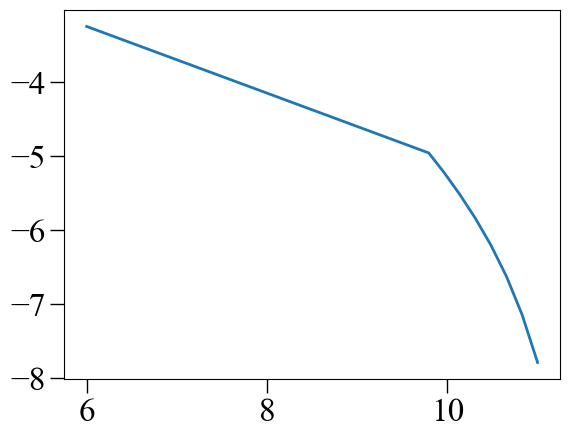

In [8]:
plt.plot(plot_logms, plot_loggsmfs)


In [52]:
plot_logms = np.linspace(6, 11, 30)
sfmr = SFMR(redshift=0.,
            flattening='moderate',
            scatter_model='none')
plot_logsfrs = np.array([sfmr.logsfr(logm) for logm in plot_logms])

In [54]:
plot_logsfrs

array([-3.22      , -3.07689655, -2.9337931 , -2.79068966, -2.64758621,
       -2.50448276, -2.36137931, -2.21827586, -2.07517241, -1.93206897,
       -1.78896552, -1.64586207, -1.50275862, -1.35965517, -1.21655172,
       -1.07344828, -0.93034483, -0.78724138, -0.64413793, -0.50103448,
       -0.35793103, -0.21482759, -0.10412334, -0.0210184 ,  0.06208653,
        0.14519147,  0.2282964 ,  0.31140134,  0.39450627,  0.47761121])

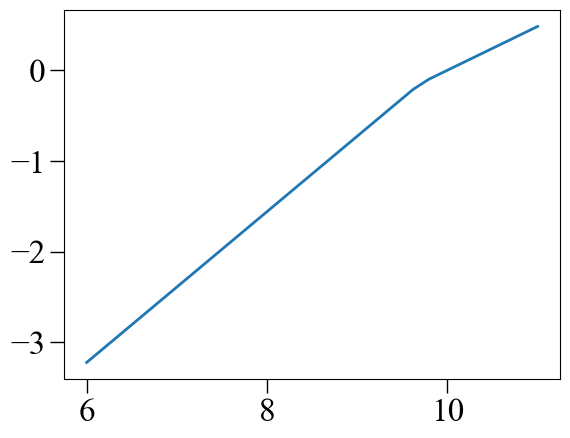

In [53]:
plt.plot(plot_logms, plot_logsfrs)


In [30]:
plot_redshifts = np.linspace(0, 8, 20)
plot_sfrds = np.zeros(plot_redshifts.shape)

flatenning = SFMR_option
fixed_slope = GSMF_option
scatter_model = 'none'
for i, redshift in enumerate(plot_redshifts):
    dVc = (4*np.pi*u.sr * cosmo.differential_comoving_volume(redshift)).to(u.Mpc**3).value
    sfmr = SFMR(redshift=redshift,
                flattening=flatenning,
                scatter_model='none')
    gsmf = GSMF(redshift=redshift,
                fixed_slope=fixed_slope)
    def f(m): 
        return 10.**sfmr.logsfr(np.log10(m)) * 10.**gsmf.log_gsmf(np.log10(m))
    sfrd = quad(f, 10.**6, 10.**12)[0]
    plot_sfrds[i] = sfrd

In [56]:
masses

array([8.44840890e+11, 6.49205490e+11, 7.36154557e+11, 7.12168608e+11,
       5.24028817e+11, 2.75174593e+11, 3.06656151e+11, 9.71516685e+11,
       9.80511416e+11, 5.74249399e+11])

In [55]:
sfmr.logsfr(12)

0.9596198328076264

In [74]:
gsmf.log_gsmf(11.4), gsmf.log_gsmf(12)

(array([-9.87325445]), array([-21.63870833]))

In [70]:
np.log10(m0), np.log10(m1)

(11.399999999999999, 12.0)

In [164]:
redshift_bins = np.linspace(0, 10, 101)
redshift_centers = np.array([(z0+z1)/2 for z0, z1 in zip(redshift_bins[:-1], redshift_bins[1:])])
mass_bins = np.logspace(6, 12, 11)
plot_sfrds = np.zeros(plot_redshifts.shape)
n_masses_per_bin = 100

flattening = SFMR_option
fixed_slope = GSMF_option
scatter_model = 'none'

sfrd_array = np.zeros((redshift_bins.shape[0]-1,))
for i, (z0, z1) in enumerate(zip(redshift_bins[:-1], redshift_bins[1:])):
    print(z0)
    gsmf = GSMF(redshift=(z0+z1)/2,
                fixed_slope=fixed_slope)
    def d_ndensity(m):
        return 10.**gsmf.log_gsmf(np.log10(m))        

    redshift_sfrds = np.zeros((mass_bins.shape[0]-1,))
    for j, (m0, m1) in enumerate(zip(mass_bins[:-1], mass_bins[1:])):
        #print(m0)
        #ndensity = quad(d_ndensity, m0, m1)[0]
        ndensity = d_ndensity((m0+m1)/2)
        ndensities = np.tile(ndensity / n_masses_per_bin, n_masses_per_bin)
        masses = np.random.choice(np.linspace(m0, m1, 100*n_masses_per_bin),
                                  p=np.ones(100*n_masses_per_bin)/(100*n_masses_per_bin),
                                  size=n_masses_per_bin)
        sfmr = SFMR(redshift=(z0+z1)/2,
                    flattening=flattening,
                    scatter_model=scatter_model)
        sfrs = np.array([10.**sfmr.logsfr(np.log10(m)) for m in masses])
        #print((z0+z1)/2, sfrs, m1-m0, ndensities)
        mass_sfrds = sfrs * ndensities
        redshift_sfrds[j] = mass_sfrds.sum()

    sfrd = redshift_sfrds.sum()
    sfrd_array[i] = sfrd

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
5.0
5.1000000000000005
5.2
5.300000000000001
5.4
5.5
5.6000000000000005
5.7
5.800000000000001
5.9
6.0
6.1000000000000005
6.2
6.300000000000001
6.4
6.5
6.6000000000000005
6.7
6.800000000000001
6.9
7.0
7.1000000000000005
7.2
7.300000000000001
7.4
7.5
7.6000000000000005
7.7
7.800000000000001
7.9
8.0
8.1
8.200000000000001
8.3
8.4
8.5
8.6
8.700000000000001
8.8
8.9
9.0
9.1
9.200000000000001
9.3
9.4
9.5
9.600000000000001
9.700000000000001
9.8
9.9


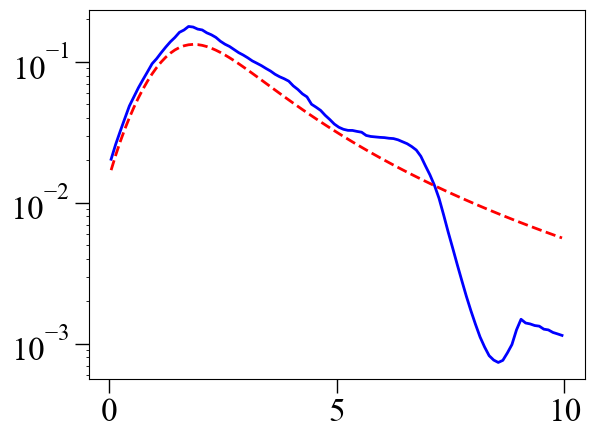

In [165]:
plt.plot(redshift_centers, sfrd_array, 'b-')
plt.plot(redshift_centers, madau2014_sfrd(redshift_centers), 'r--')
plt.yscale('log')

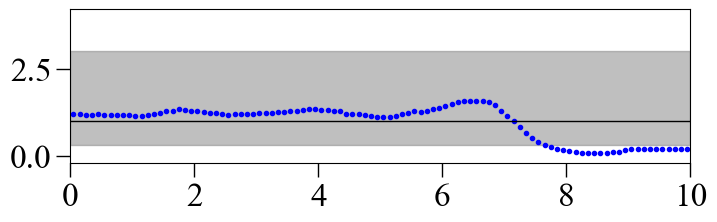

In [190]:
fig = plt.figure(figsize=(8, 2))
plt.plot(redshift_centers, sfrd_array/madau2014_sfrd(redshift_centers), 'b.')
plt.ylim(-0.2, 4.2)
plt.xlim(0, 10)
plt.hlines(1, 0, 10, color='black', lw=1)
plt.fill_between([0,10], [1/3,1/3], [3,3], color='gray', alpha=0.5)

#plt.yscale('log')

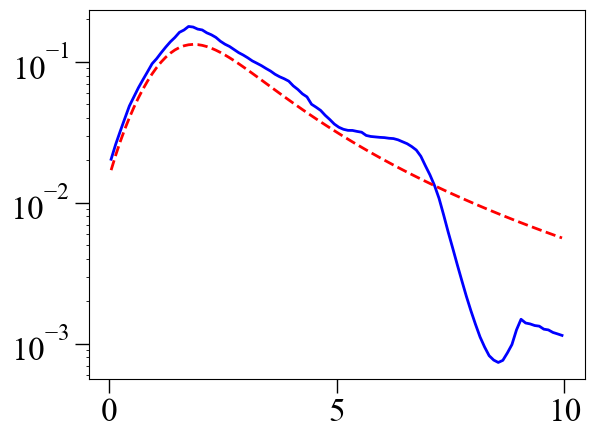

In [188]:
plt.plot(redshift_centers, sfrd_array, 'b-')
plt.plot(redshift_centers, madau2014_sfrd(redshift_centers), 'r--')
plt.yscale('log')

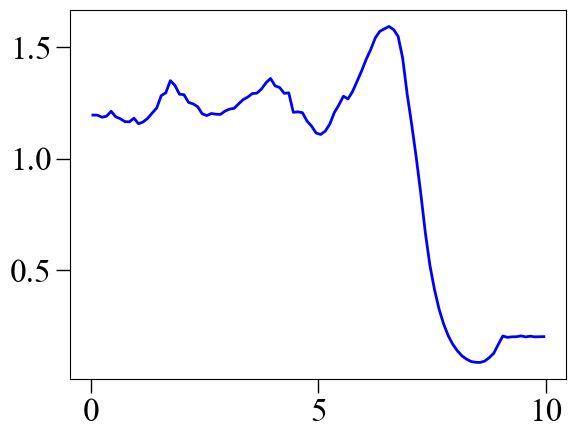

In [187]:
plt.plot(redshift_centers, sfrd_array/madau2014_sfrd(redshift_centers), 'b-')
#plt.yscale('log')

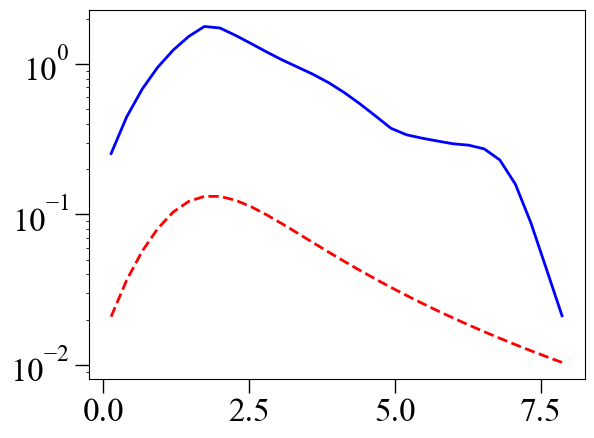

In [124]:
plt.plot(redshift_centers, sfrd_array, 'b-')
plt.plot(redshift_centers, madau2014_sfrd(redshift_centers), 'r--')
plt.yscale('log')

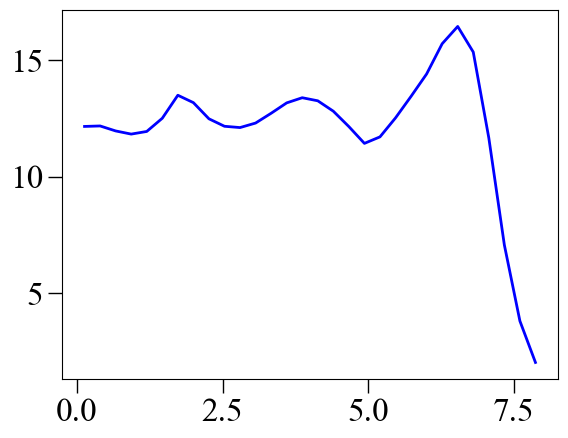

In [125]:
plt.plot(redshift_centers, sfrd_array/madau2014_sfrd(redshift_centers), 'b-')
#plt.yscale('log')

In [120]:
gsmf.log_gsmf(12)

array([-21.02423257])

In [32]:
10**sfmr.logsfr(6) * 10.**gsmf.log_gsmf(6)

array([2.13654517e-05])

In [33]:
def f(m): 
        return 10.**sfmr.logsfr(np.log10(m)) * 10.**gsmf.log_gsmf(np.log10(m))
quad(f, 1.e6, 1.e12)

(13621378.924122227, 0.06828122906184325)

In [34]:
def f(m): 
        return 10.**sfmr.logsfr(m) * 10.**gsmf.log_gsmf(m)
quad(f, 6, 12)

(0.0009264638875419027, 1.0166520722607215e-08)

/tmp/ipykernel_90576/2828432095.py:2: RuntimeWarning: overflow encountered in scalar power
  return 10.**sfmr.logsfr(m) * 10.**gsmf.log_gsmf(m)
/home/lucasmdesa/Documents/GitHub/BOSSA/notebooks/../src/sfh.py:894: RuntimeWarning: overflow encountered in scalar power
  log_sch = (logphi + (a + 1) * (logm - logm_co) - 10 ** (logm - logm_co)


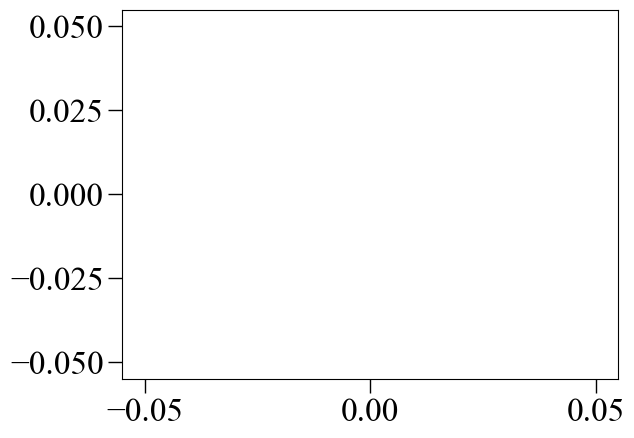

In [35]:
plt.plot(np.linspace(6, 12, 20), np.log10([f(m) for m in 10.**np.linspace(6, 12, 20)]))

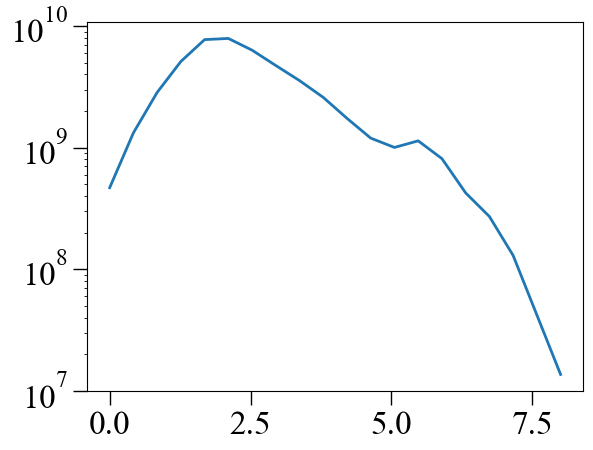

In [36]:
plt.plot(plot_redshifts, plot_sfrds)
plt.yscale('log')

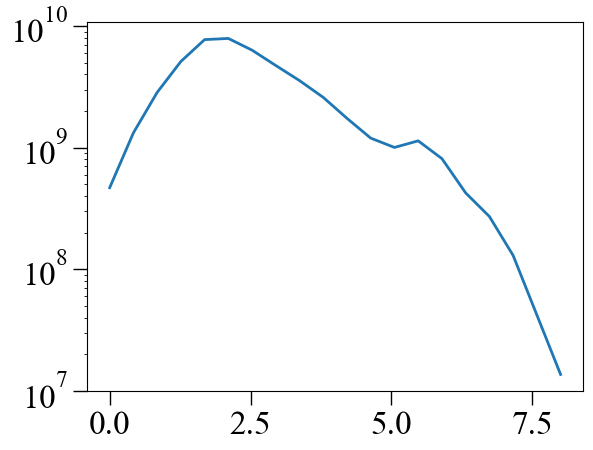

In [37]:
plt.plot(plot_redshifts, plot_sfrds)
plt.yscale('log')